# Import Dependencies

In [1]:
import numpy as np
import cv2
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Get the Data

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocessing

In [3]:
# reshape mnist data
print(x_train.shape)
print(x_test.shape)
x_train_resized = np.array([cv2.resize(sample, dsize=(48, 48), 
                                       interpolation=cv2.INTER_CUBIC) for sample in x_train])
x_test_resized = np.array([cv2.resize(sample, dsize=(48, 48), 
                                      interpolation=cv2.INTER_CUBIC) for sample in x_test])
print(x_train_resized.shape)
print(x_test_resized.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 48, 48)
(10000, 48, 48)


In [4]:
# from grayscale to rgb since this is the required input for the VGG19 algorithm
x_train_resized = np.array([np.dstack((sample, sample, sample)) for sample in x_train_resized])
x_test_resized = np.array([np.dstack((sample, sample, sample)) for sample in x_test_resized])

In [5]:
print(x_train_resized.shape)
print(x_test_resized.shape)

(60000, 48, 48, 3)
(10000, 48, 48, 3)


# Building the Model

In [6]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape=x_train_resized[0].shape)

print('layers in pre-trained model: {}'.format(len(model.layers)))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers:
    layer.trainable = False
    
model.summary()

nb_classes = len(np.unique(y_train))
    
# Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
output_layer = Dense(nb_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(input=model.input, output=output_layer)

layers in pre-trained model: 22
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [7]:
# compile the model 
model_final.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
    metrics=["accuracy"]
)

In [8]:
nb_train_samples = int(len(x_train) * 0.85)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

x_val = x_train_resized[nb_train_samples:]
y_val = y_train_categorical[nb_train_samples:]

# Training

In [11]:
# Train the model 
history = model_final.fit(
    x_train_resized[:nb_train_samples],
    y_train_categorical[:nb_train_samples],
    validation_data=(x_val, y_val),
    batch_size=50,
    epochs=10,
)

Train on 51000 samples, validate on 9000 samples
Epoch 1/10
51000/51000 [==============================] - 903s 18ms/step - loss: 0.6407 - acc: 0.8128 - val_loss: 0.2495 - val_acc: 0.9219
Epoch 2/10
51000/51000 [==============================] - 902s 18ms/step - loss: 0.3878 - acc: 0.8777 - val_loss: 0.2083 - val_acc: 0.9351
Epoch 3/10
51000/51000 [==============================] - 845s 17ms/step - loss: 0.3244 - acc: 0.8986 - val_loss: 0.1849 - val_acc: 0.9433
Epoch 4/10
51000/51000 [==============================] - 856s 17ms/step - loss: 0.2921 - acc: 0.9090 - val_loss: 0.1706 - val_acc: 0.9472
Epoch 5/10
51000/51000 [==============================] - 883s 17ms/step - loss: 0.2634 - acc: 0.9180 - val_loss: 0.1595 - val_acc: 0.9516
Epoch 6/10
51000/51000 [==============================] - 865s 17ms/step - loss: 0.2440 - acc: 0.9220 - val_loss: 0.1474 - val_acc: 0.9532
Epoch 7/10
51000/51000 [==============================] - 845s 17ms/step - loss: 0.2284 - acc: 0.9281 - val_loss: 0.1

# Evaluation

In [12]:
model_final.evaluate(x_test_resized, y_test_categorical)

10000/10000 [==============================] - 145s 14ms/step


[0.14191905381083489, 0.95489999999999997]

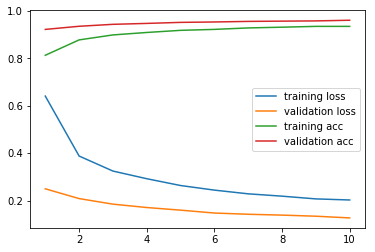

In [13]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.legend()
plt.show()

In [14]:
print(val_acc[9])

0.960555556748
